In [1]:
# Setup to analyse an MDP Playground experiment
from mdp_playground.analysis import MDPP_Analysis
# Set dir_name to the location where the CSV files from running an experiment were saved
dir_name = '/home/rajanr/mdpp_12680567' # 12348452, 12354801, 12362352, 12495380, 12499228, 12500667, 12503823, 12505701, 12506870, 12532831, 12536403, 12540214, 12546339, 12550729, 12552121, 12578498, 12578770, 12579037, 12579179, 12579254, 12579419,
# 12634504, 12678295, 12680567
# Set exp_name to the name that was given to the experiment when running it
exp_name = 'ddpg_move_to_a_point_p_noise'
# Set the following to True to save PDFs of plots that you generate below
save_fig = True

In [2]:
# Data loading
mdpp_analysis = MDPP_Analysis()
train_stats, eval_stats, train_curves, eval_curves = mdpp_analysis.load_data(dir_name, exp_name)

Loading data from a sequential run/already combined runs of experiment configurations.
Training stats read (rows, columns): (1520, 19)
train stats shape: (1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 10, 3)
eval stats shape: (1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 10, 3)
Dimension varied: transition_noise . The values it took: ['0.0', '0.02', '0.1', '0.25', '0.5', '1.0', '2.0', '5.0'] . Number of values it took: 8 . Index in loaded data: 5


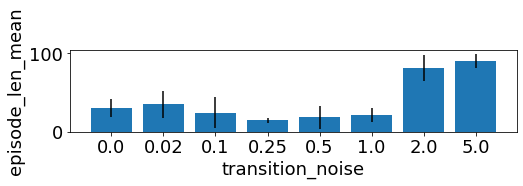

In [4]:
# 1-D: Plots showing reward after 20k timesteps when varying a single meta-feature
# Plots across 10 runs: Training: with std dev across the runs
mdpp_analysis.plot_1d_dimensions(train_stats, save_fig, metric_num=-2)

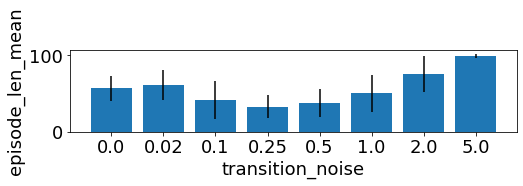

In [5]:
# Plots across 10 runs: Evaluation: with std dev across the runs
mdpp_analysis.plot_1d_dimensions(eval_stats, save_fig, train=False, metric_num=-2)

In [ ]:
# 2-D heatmap plots across 10 runs: Training runs: with std dev across the runs
# There seems to be a bug with matplotlib - x and y axes tick labels are not correctly set even though we pass them. Please feel free to look into the code and suggest a correction if you find it.
mdpp_analysis.plot_2d_heatmap(train_stats, save_fig)

In [ ]:
# 2-D heatmap plots across 10 runs: Evaluation runs: with std dev across the runs
mdpp_analysis.plot_2d_heatmap(eval_stats, save_fig, train=False)

In [ ]:
# Plot learning curves: Training: Each curve corresponds to a different seed for the agent
mdpp_analysis.plot_learning_curves(train_curves, save_fig, metric_num=-2)

In [ ]:
len(train_curves)
train_curves[-1].shape
eval_curves[-1].shape

In [ ]:
# Plot learning curves: Evaluation: Each curve corresponds to a different seed for the agent
mdpp_analysis.plot_learning_curves(eval_curves, save_fig, train=False)

In [ ]:
# some more analysis
import os
import sys
import numpy as np
from scipy.stats import spearmanr as spm
from scipy.stats import pearsonr as prs
import matplotlib.pyplot as plt

dir_name_config = 'experiments/'
file_ = dir_name_config + exp_name

config_file_path = os.path.abspath('/'.join(file_.split('/')[:-1]))
# print(file_.split('/')[:-1])
print("config_file_path:", config_file_path)
sys.path.insert(1, config_file_path) #hack
import importlib
config = importlib.import_module(file_.split('/')[-1], package=None)
print("Number of seeds for environment:", config.num_seeds)

value_tuples = []
for config_type, config_dict in config.var_configs.items():
    for key in config_dict:
        if 'seed' in key:
            print(key)
            pass
        else:
            assert type(config.var_configs[config_type][key]) == list, "var_config should be a dict of dicts with lists as the leaf values to allow each configuration option to take multiple possible values"
            value_tuples.append(config.var_configs[config_type][key])

import itertools
cartesian_product_configs = list(itertools.product(*value_tuples))
print("Total number of configs. to run:", len(cartesian_product_configs))
print(mdpp_analysis.axis_labels)
# import itertools
# cartesian_product_configs = list(itertools.product(*config_vals))
for i in range(len(train_stats.shape)):
    if train_stats.shape[i] > 1:
        dummy_seeds_axis = i
        break
print("dummy_seeds_axis:", dummy_seeds_axis, len(train_stats.shape))
mean_data_eval = np.mean(eval_stats[..., -2], axis=dummy_seeds_axis)
std_data_ = np.std(eval_stats[..., -2], axis=dummy_seeds_axis)

def analysis(train_stats):
    mean_data_ = np.mean(train_stats[..., -2], axis=dummy_seeds_axis)
    std_data_ = np.std(train_stats[..., -2], axis=dummy_seeds_axis)
    print(mean_data_.shape, train_stats[..., -2].shape)
    flattened_mean = np.ravel(mean_data_)
    flattened_std = np.ravel(std_data_)
    ranks = np.argsort(flattened_mean)[::-1]
    print('sort of indices:\n', ranks)
    ranks_with_std = np.argsort(flattened_mean - flattened_std)[::-1]
    print('sort of indices (with std taken into account):\n', ranks_with_std)
    sorted_vals = np.sort(flattened_mean)[::-1]
    print('sort of values:\n', sorted_vals)
    sorted_vals_with_std = np.sort(flattened_mean - flattened_std)[::-1]
    print('sort of values (with std taken into account):\n', sorted_vals_with_std)
    print("TOP 3 configs (with std taken into account):")
    print(cartesian_product_configs[np.argsort(flattened_mean - flattened_std)[-1]]) 
    print(cartesian_product_configs[np.argsort(flattened_mean - flattened_std)[-2]])
    print(cartesian_product_configs[np.argsort(flattened_mean - flattened_std)[-3]])
    print("\nBOTTOM 3 configs (with std taken into account):")
    print(cartesian_product_configs[np.argsort(flattened_mean - flattened_std)[0]]) 
    print(cartesian_product_configs[np.argsort(flattened_mean - flattened_std)[1]])
    print(cartesian_product_configs[np.argsort(flattened_mean - flattened_std)[2]])
    plt.figure(figsize=(30, 1.5))
    plt.bar([i for i in range(len(flattened_mean))], flattened_mean, yerr=flattened_std)
    plt.show()
    return flattened_mean, flattened_mean - flattened_std
    
sorted_vals_t, sorted_vals_with_std_t = analysis(train_stats)
sorted_vals_e, sorted_vals_with_std_e = analysis(eval_stats)
print(spm(sorted_vals_t, sorted_vals_e))
print(spm(sorted_vals_t, sorted_vals_with_std_t))
print(spm(sorted_vals_with_std_t, sorted_vals_with_std_e))
print(spm(sorted_vals_e, sorted_vals_with_std_e))
